NoteBook link:
https://colab.research.google.com/drive/1cBEOeSnu-PZdp6P1opq3XR7vWFUKcQT-?usp=sharing

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import pandas
import pywt

In [12]:
mona = cv2.imread('mona lisa.jpg', cv2.IMREAD_GRAYSCALE)
Lena = cv2.imread('Lena.bmp', cv2.IMREAD_GRAYSCALE)

In [14]:
def imshow(*args, title=None, figsize=20, to_rgb=True, fontsize=12):
    if isinstance(figsize, int):
        figsize = (figsize, figsize)
    images = args[0] if type(args[0]) is list else list(args)
    if to_rgb:
        images = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), images))
    if title is not None:
        assert len(title) == len(images), "Please provide a title for each image."
    plt.figure(figsize=figsize)
    for i in range(1, len(images)+1):
        plt.subplot(1, len(images), i)
        if title is not None:
            plt.title(title[i-1], fontsize=fontsize)
        if images[i-1].ndim == 2:
            plt.imshow(images[i-1], cmap='gray')
        else:
            plt.imshow(images[i-1])
        plt.axis('off')

In [4]:
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv2.pyrDown(lower)
        gaussian_pyr.append(np.float32(lower).astype('uint8'))
    return gaussian_pyr

In [66]:
def ds_avg(im):
    original_width = im.shape[1]
    original_height = im.shape[0]
    width = original_width // 2
    height = original_height // 2
    resized_image = np.zeros(shape=(height, width), dtype=np.uint8)
    scale = 2
    for i in range(height):
        for j in range(width):
            temp = 0
            for x in range(scale):
                for y in range(scale):
                    temp += im[i*scale + x, j*scale + y]
            resized_image[i, j] = temp/(scale*scale)

    return resized_image

In [5]:
def laplacian_pyramid(gaussian_pyr):
    laplacian_top = gaussian_pyr[-1]
    num_levels = len(gaussian_pyr) - 1
    
    laplacian_pyr = [laplacian_top]
    for i in range(num_levels,0,-1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)
    return laplacian_pyr

In [67]:
def nearest(input):
  sx,sy = input.shape
  output = np.zeros((sx*2, sy*2), input.dtype)
  for y in range(len(output)):
    for x in range(len(output[y])):
      proj_x = x // 2
      proj_y = y // 2
      output[y][x] = input[proj_y][proj_x]

  return output

#5.1.1

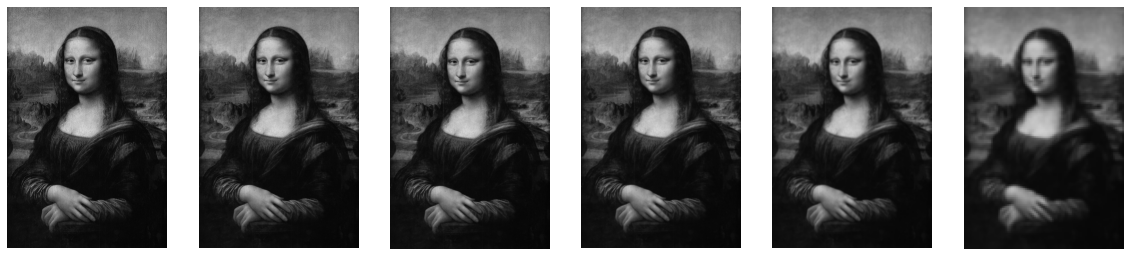

In [43]:
g_pyramid = gaussian_pyramid(mona, 5)
imshow(g_pyramid)

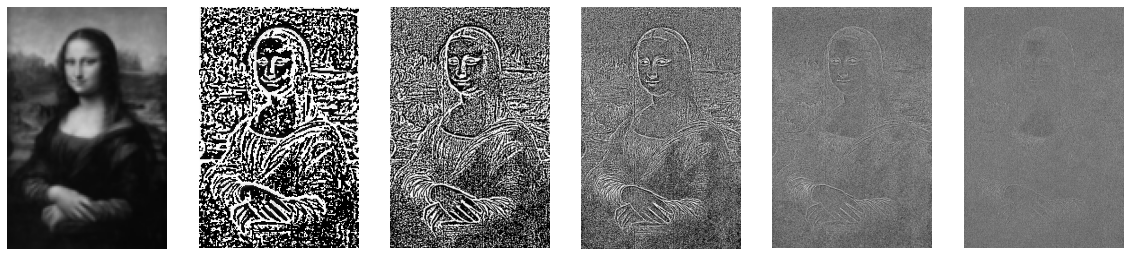

In [19]:
l_pyramid = laplacian_pyramid(g_pyramid)
imshow(l_pyramid)

#5.1.2

In [21]:
def get_gaussian_kernel(k, sigma=-1):
    kernel = cv2.getGaussianKernel(k, sigma)
    kernel /= kernel[0,0]
    kernel = kernel @ kernel.T
    kernel /= kernel.sum()
    return kernel

def normalize(img):
    img = ((img - img.min()) / (img.max() - img.min())) * 255
    return np.round(img).astype('uint8')

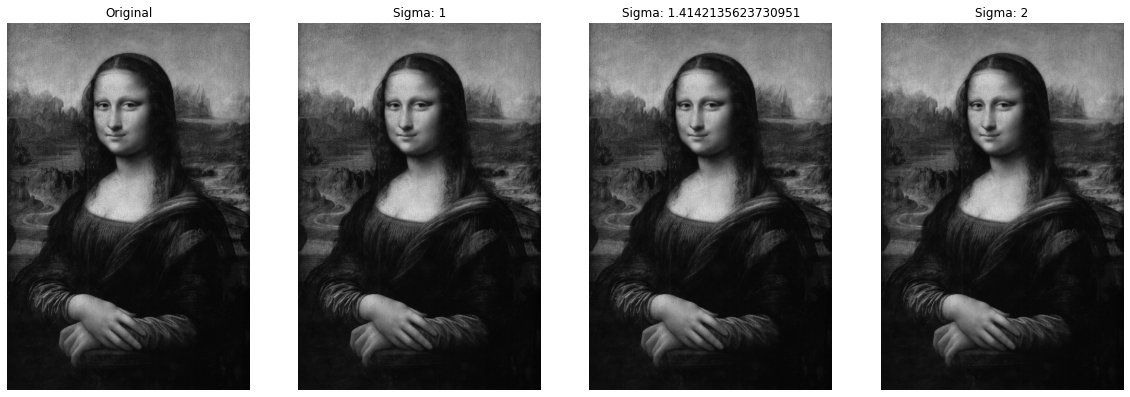

In [33]:
images = [mona]
titles = ['Original']
for sigma in [1, np.sqrt(2), 2]:
    kernel = get_gaussian_kernel(int(4 * sigma + 1), sigma)
    out = cv2.filter2D(mona, -1, kernel)
    images.append(out)
    titles.append(f'Sigma: {sigma}')

imshow(images, title=titles, figsize=20)

#5.1.3

As we know, the size of the image is halved in each step, so if we consider the first level equal to the original image itself, we need 1+j steps to reach one pixel. The total number of pixels that make up the pyramid, if the last level is a pixel, is equal to the sum of a geometric sequence, the sum of these levels is equal to 4/2x3N. Therefore, we only need to keep more pixels as 1/2X3N.

Considering the **advantages** that using pyramids have for us, such as Alternative representation, we can use each of the images at different levels as different scales of that image. Another use of it is **detail manipulation** or **image compression**, which is widely used in image processing.

The total number of pixels of all levels until reaching one pixel is equal to 349525, which is obtained from the relationship 4/3 * 512 **2.

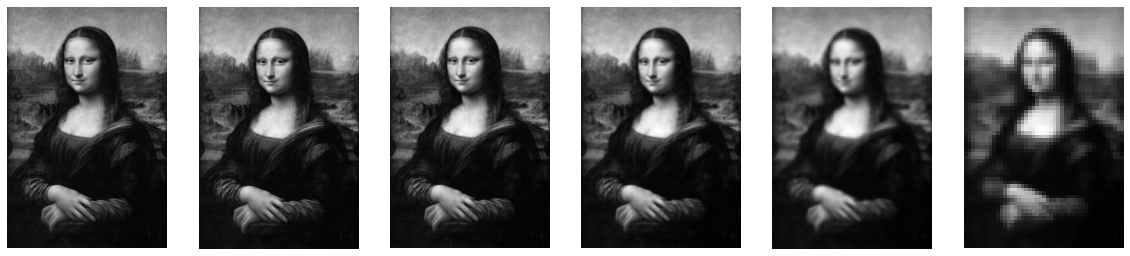

In [63]:
x = []
for i in range(len(g_pyramid)):  
  x.append(cv2.pyrDown(g_pyramid[i]))
  
imshow(x, to_rgb = False)

#5.1.4

By using downsampling with the pixel removal method, we will halve the size of the image and by using these two functions, we can create up to three levels of the pyramid.

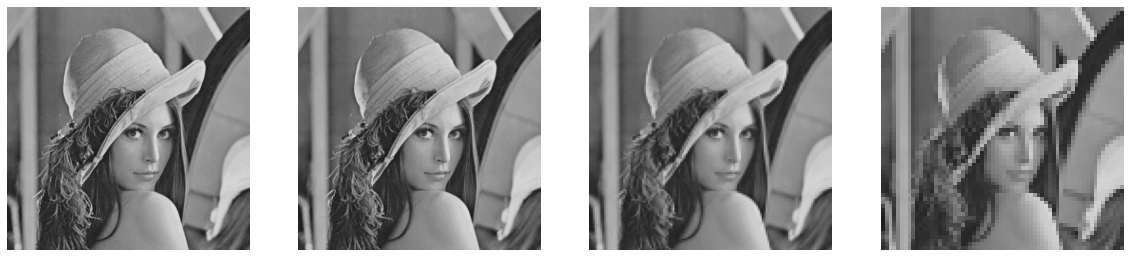

In [70]:
lena = Lena.copy()
img = [lena]
for i in range(3):
    lena = ds_avg(lena)
    img.append(lena)

imshow(img)

Before down sampling the image, we first calculate the difference of the image after applying the filter with the original image, and the first level of the residual pyramid will be obtained.

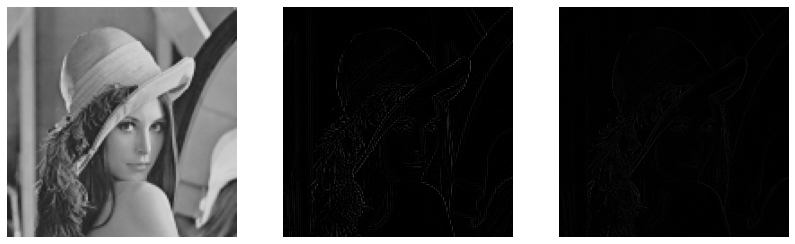

In [71]:
IMG = [img[2]]
for i in range(2,0,-1):
    GE = nearest(img[i])
    L = cv2.subtract(img[i-1],GE)
    IMG.append(L)

imshow(IMG, figsize=14)

#5.1.5

The output of this function will be 4 images with half the size of the original image, including LL and LH, HL and HH. The LL image is the main image with half the size of the previous image, which will be used to make the pyramid, and the other three images will give the edges of the image in 3 horizontal, vertical and diagonal directions.

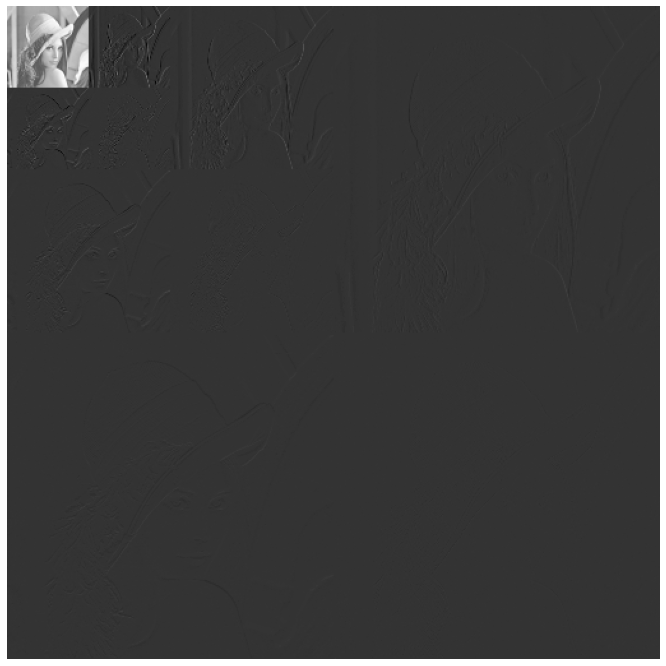

In [74]:
# wavelet transform
coeffs = pywt.wavedec2(Lena, 'haar', mode='periodization', level=3)

# Put coefficients in a matrix
c_matrix, c_slices = pywt.coeffs_to_array(coeffs)

# Plot
plt.figure(figsize=(12, 12))
plt.imshow(c_matrix, cmap='gray')
plt.axis('off')
plt.show()

##Result

The difference that seems to be that the use of a two-by-two filter box may not be able to reduce the maximum frequency of the image, and for this reason, we may encounter the Aliasing phenomenon when using a two-by-two filter box. While Aliasing will not occur when using haar wavelet mother.